#Домашнее задание по лекции "Работа с текстом" DLL



1. Скачать датасет с фразами Симпсонов - [https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data](https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data)
2. Обучить word2vec на фразах персонажей
3. Визуализировать embeddings по самым частотным словам (top 1000)
4. Найти самые близкие слова для: homer - marge + bart bart - lisa + school marge - homer + home
5. *Попробовать построить классификатор bart/lisa с использованием этих эмбеддингов

### импорт библиотек

In [ ]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 62.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=a68706f894210130a21a13a1d4a57fdfee47fe18754637bce18d6e31d99bf110
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
import pandas as pd
import re
import pymorphy2
import time
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from gensim import models
import gensim
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

ModuleNotFoundError: ignored

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
import numpy as np

In [ ]:
import warnings
warnings.filterwarnings("ignore")

### загрузка данных

In [ ]:
!wget https://raw.githubusercontent.com/sujanjoejacob/Text-mining-with-Simpsons-Data/master/simpsons_script_lines.csv.zip

--2023-09-29 10:23:34--  https://raw.githubusercontent.com/sujanjoejacob/Text-mining-with-Simpsons-Data/master/simpsons_script_lines.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9163442 (8.7M) [application/zip]
Saving to: ‘simpsons_script_lines.csv.zip.1’

simpsons_script_lin 100%[===================>]   8.74M  --.-KB/s    in 0.1s    

2023-09-29 10:23:34 (79.5 MB/s) - ‘simpsons_script_lines.csv.zip.1’ saved [9163442/9163442]



In [ ]:
!unzip simpsons_script_lines.csv.zip

Archive:  simpsons_script_lines.csv.zip
replace simpsons_script_lines.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
df = pd.read_csv('/content/simpsons_script_lines.csv', sep = ',', on_bad_lines='skip')
df.head(20)

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31.0
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3.0
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22.0
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living,5.0
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,True,40.0,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33.0
5,9554,32,214,Martin Prince: (HOARSE WHISPER) I don't think ...,877000,True,38.0,3.0,Martin Prince,Springfield Elementary School,I don't think there's anything left to say.,i dont think theres anything left to say,8.0
6,9555,32,215,Edna Krabappel-Flanders: Bart?,881000,True,40.0,3.0,Edna Krabappel-Flanders,Springfield Elementary School,Bart?,bart,1.0
7,9556,32,216,Bart Simpson: Victory party under the slide!,882000,True,8.0,3.0,Bart Simpson,Springfield Elementary School,Victory party under the slide!,victory party under the slide,5.0
8,9557,32,217,(Apartment Building: Ext. apartment building -...,889000,False,NaN,374.0,NaN,Apartment Building,NaN,NaN,NaN
9,9558,32,218,Lisa Simpson: (CALLING) Mr. Bergstrom! Mr. Ber...,889000,True,9.0,374.0,Lisa Simpson,Apartment Building,Mr. Bergstrom! Mr. Bergstrom!,mr bergstrom mr bergstrom,4.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158248 entries, 0 to 158247
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  158248 non-null  int64  
 1   episode_id          158248 non-null  int64  
 2   number              158248 non-null  int64  
 3   raw_text            158248 non-null  object 
 4   timestamp_in_ms     158248 non-null  object 
 5   speaking_line       158248 non-null  object 
 6   character_id        140727 non-null  object 
 7   location_id         157841 non-null  float64
 8   raw_character_text  140726 non-null  object 
 9   raw_location_text   157840 non-null  object 
 10  spoken_words        132089 non-null  object 
 11  normalized_text     132064 non-null  object 
 12  word_count          132089 non-null  float64
dtypes: float64(2), int64(3), object(8)
memory usage: 15.7+ MB


In [ ]:
df.normalized_text.isnull().value_counts()

False    132064
True      26184
Name: normalized_text, dtype: int64

In [ ]:
df.spoken_words.isnull().value_counts()

False    132089
True      26159
Name: spoken_words, dtype: int64

In [ ]:
df.speaking_line.unique()

array([True, False, 'true', 'false',
       'Guess what. I also play Frankenstein!'], dtype=object)

In [ ]:
# оставим строки с наличием реплик
df = df.loc[((df['speaking_line'] == True)|(df['speaking_line' ] == 'true'))]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132089 entries, 0 to 158247
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  132089 non-null  int64  
 1   episode_id          132089 non-null  int64  
 2   number              132089 non-null  int64  
 3   raw_text            132089 non-null  object 
 4   timestamp_in_ms     132089 non-null  object 
 5   speaking_line       132089 non-null  object 
 6   character_id        132087 non-null  object 
 7   location_id         131712 non-null  float64
 8   raw_character_text  132087 non-null  object 
 9   raw_location_text   131712 non-null  object 
 10  spoken_words        132089 non-null  object 
 11  normalized_text     132064 non-null  object 
 12  word_count          132089 non-null  float64
dtypes: float64(2), int64(3), object(8)
memory usage: 14.1+ MB


In [ ]:
# в колонке с нормализованными репликами осталось 25 NaN
df.normalized_text.isnull().value_counts()

False    132064
True         25
Name: normalized_text, dtype: int64

In [ ]:
# Замена NaN на нули
df['normalized_text'] = df['normalized_text'].fillna(0)
# Удаление строк с normalized_text равным нулю
df = df.loc[((df['normalized_text'] != 0))]

In [ ]:
df.normalized_text.isnull().value_counts()

False    132064
Name: normalized_text, dtype: int64

In [ ]:
 nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# преобразование колонки с репликами в список
repliks = df['normalized_text'].tolist()  # колонка с предобработанными текстами
print(len(repliks))

132064


In [ ]:
repliks[:10]

['no actually it was a little of both sometimes when a disease is in all the magazines and all the news shows its only natural that you think you have it',
 'wheres mr bergstrom',
 'i dont know although id sure like to talk to him he didnt touch my lesson plan what did he teach you',
 'that life is worth living',
 'the polls will be open from now until the end of recess now just in case any of you have decided to put any thought into this well have our final statements martin',
 'i dont think theres anything left to say',
 'bart',
 'victory party under the slide',
 'mr bergstrom mr bergstrom',
 'hey hey he moved out this morning he must have a new job -- he took his copernicus costume']

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# препроцессинг текстов реплик
def preprocess(text):
    morph = pymorphy2.MorphAnalyzer()
    stop_words = stopwords.words('english')
    wocab = []
    for el in text:
        sentences = nltk.sent_tokenize(el, language="english")
        for sentence in sentences:
            sentence_ = re.sub(r"[^A-Za-z ]","", sentence)
            tokens = nltk.word_tokenize(sentence_)
            tokens = [i for i in tokens if (i not in stop_words)]
            tokens = list(map(lambda x: morph.parse(x)[0].normal_form, tokens))
            wocab.append(tokens)
    return wocab

In [ ]:
wocab = preprocess(repliks)

In [ ]:
wocab[:3]

[['actually',
  'little',
  'sometimes',
  'disease',
  'magazines',
  'news',
  'shows',
  'natural',
  'think'],
 ['wheres', 'mr', 'bergstrom'],
 ['dont',
  'know',
  'although',
  'id',
  'sure',
  'like',
  'talk',
  'didnt',
  'touch',
  'lesson',
  'plan',
  'teach']]

### Обучить word2vec на фразах персонажей

In [ ]:
model = models.Word2Vec(wocab, workers=4, vector_size=100, min_count=3, window=5)

# model = models.Word2Vec(
#     min_count = 10, # игнорировать все слова с частотой встречаемости меньше, чем это значение.
#     window = 2, # размер контекстного окна, обозначает диапазон контекста.
#     vector_size = 300, # размер векторного представления слова (word embedding).
#     negative = 10, # сколько неконтекстных слов учитывать в обучении, используя negative sampling,
#     alpha = 0.03, # начальный learning_rate, используемый в алгоритме обратного распространения ошибки (Backpropogation)
#     min_alpha = 0.0007, # минимальное значение learning_rate, на которое может опуститься в процессе обучения
#     sample = 6e-5,
#     sg=1 )# если 1, то используется реализация Skip-gram; если 0, то CBOW.

model.build_vocab(wocab) # обучение на нашем словаре из датасета
model.train(wocab, total_examples=model.corpus_count, epochs=model.epochs)

(3221735, 3687410)

In [ ]:
model.corpus_total_words

737482

In [ ]:
model.wv.get_vector("victory")

array([-0.76107126,  1.1130431 ,  0.35025138,  0.28491187,  0.30179074,
       -0.31350133,  0.2684595 ,  0.2726078 ,  1.0249039 , -0.9581578 ,
       -0.56322676, -0.62466794,  0.698481  ,  0.37724042,  0.4874223 ,
        0.45695102, -0.08633452, -1.2606882 ,  0.5443135 , -0.7517236 ,
       -0.05026595,  0.9414368 ,  0.11408627, -0.2787565 ,  0.6117368 ,
        0.21895681,  0.2083433 , -0.6063104 ,  0.30338874, -0.10643999,
        0.67304164,  0.0484118 , -0.2719587 , -0.78768533, -0.84557164,
        0.47286585, -0.419285  , -0.21391702,  0.46650138, -1.1261163 ,
        0.6431888 , -0.8853834 , -0.03605938, -0.63201845, -0.05666422,
       -0.8989023 , -0.1368118 , -0.32492357,  0.2079862 , -0.5032355 ,
       -0.00905215, -0.65911233, -0.56381816, -0.566821  ,  0.11226383,
        0.03353715,  0.20622894, -0.3671204 , -0.5518962 ,  0.41712663,
        1.1032865 ,  0.53739905,  0.208355  ,  0.52965266, -0.77805096,
        0.20967619, -0.6775595 ,  0.77596074, -0.10650907,  0.69

### Найти самые близкие слова

In [ ]:
# вывод близких слов
model.wv.most_similar(positive=["think"], topn=5)

[('thinking', 0.6962056756019592),
 ('know', 0.6955190300941467),
 ('hurt', 0.68890380859375),
 ('wonder', 0.687472403049469),
 ('bet', 0.6752065420150757)]

In [ ]:
model.wv.most_similar(positive=["lisa"], topn=1)

[('bart', 0.8628193736076355)]

In [ ]:
# близкие слова
model.wv.most_similar(positive=["lisa", "marge"])

[('bart', 0.8229429125785828),
 ('homer', 0.7797048091888428),
 ('sweetie', 0.7401516437530518),
 ('grampa', 0.7351557612419128),
 ('honey', 0.7318949699401855),
 ('abe', 0.7267431020736694),
 ('maggie', 0.7156968116760254),
 ('mother', 0.7151685953140259),
 ('edna', 0.7113345265388489),
 ('eliza', 0.7048037648200989)]

In [ ]:
# Найти самые близкие слова для: homer - marge + bart,
model.wv.most_similar(positive=["marge", "bart"], negative=["homer"])

[('lisa', 0.7917193174362183),
 ('honey', 0.6595156192779541),
 ('maggie', 0.6357178688049316),
 ('sweetie', 0.6350638270378113),
 ('kid', 0.6302402019500732),
 ('mother', 0.6203329563140869),
 ('helping', 0.6162747144699097),
 ('sister', 0.61374831199646),
 ('stupidest', 0.6074283719062805),
 ('kids', 0.6020569801330566)]

In [ ]:
#  bart - lisa + school
model.wv.most_similar(positive=["lisa", "school"], negative=["bart"])

[('tricity', 0.6566483378410339),
 ('badges', 0.6086469888687134),
 ('left', 0.5999690890312195),
 ('checkmate', 0.5811675190925598),
 ('tale', 0.579921543598175),
 ('called', 0.5693714618682861),
 ('squishee', 0.5688117146492004),
 ('room', 0.5666747093200684),
 ('town', 0.566547155380249),
 ('music', 0.5520992875099182)]

In [ ]:
# marge - homer + home
model.wv.most_similar(positive=["homer", "home"], negative=["marge"])

[('back', 0.7265704870223999),
 ('moes', 0.6790823340415955),
 ('early', 0.6488784551620483),
 ('outside', 0.6184561252593994),
 ('jail', 0.5983770489692688),
 ('late', 0.5967541933059692),
 ('visit', 0.5750067830085754),
 ('tomorrow', 0.5725235342979431),
 ('ride', 0.5717312097549438),
 ('bike', 0.5684101581573486)]

### Визуализировать embeddings по самым частотным словам (top 1000)

In [ ]:
# импортируем необходимые библиотеки
from nltk import FreqDist
from tqdm import tqdm_notebook as tqdm
from sklearn.manifold import TSNE

# model.wv.get_item()
# test = {}
top_words = []

# строим простой словарь частотности употреблений всех слов

fd = FreqDist()
for s in tqdm(wocab):
    fd.update(s)

#оставляем только 1000 самых частых слов
for w in fd.most_common(1000):
    top_words.append(w[0])

print(top_words[:10:])
top_words_vec = model.wv[top_words]

  0%|          | 0/132064 [00:00<?, ?it/s]

['im', 'oh', 'well', 'dont', 'like', 'get', 'youre', 'know', 'one', 'got']


In [ ]:
len(top_words_vec)

1000

In [ ]:
fd = FreqDist() # определение частотности
top_words = []
top_only_words = []
top_words_f =[]

# создание массива с 100 топ-слов
for text in wocab:
    fd.update(text)
for i in fd.most_common(1000):
    top_words.append(i)
    top_only_words.append(i[0])
    top_words_f.append(i[1])

In [ ]:
top_words_vec = model.wv[top_only_words]
tsne = TSNE(n_components=2, random_state=0)
top_words_tsne = tsne.fit_transform(top_words_vec)

In [ ]:
# https://docs.bokeh.org/en/latest/
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(title="T-SNE для топ-100")

source = ColumnDataSource(
    data=dict(
        x1=top_words_tsne[:,0],
        x2=top_words_tsne[:,1],
        names=top_only_words))

p.scatter(
    x="x1",
    y="x2",
    size=5,
    source=source)

labels = LabelSet(
    x="x1",
    y="x2",
    text="names",
    y_offset=6,
    text_font_size="5pt",
    text_color="#555555",
    source=source,
    text_align='center')

p.add_layout(labels)
show(p)

In [ ]:
import plotly.express as px
fig = px.scatter(None, x=top_words_tsne[:,0], y=top_words_tsne[:,1],
labels={
"x": "x1",
"y": "x2",
},
opacity=1,
color=top_words,
hover_data=[top_words]
)

# Изменение цвета фона графика
fig.update_layout(dict(plot_bgcolor = 'white'))

# Обновление линий осей
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
showline=True, linewidth=1, linecolor='black')

# Установка названия рисунка
fig.update_layout(title_text="t-SNE для топ-1000")

# Обновление размера маркера
fig.update_traces(marker=dict(size=10))

In [ ]:
!pip3 install wordcloud

In [ ]:
from wordcloud import WordCloud

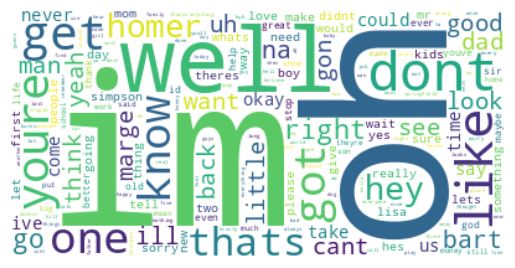

In [ ]:
word_freq = [i for i in top_words]
wd = WordCloud(background_color = 'white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### 5* Попробовать построить классификатор bart/lisa с использованием этих эмбеддингов

In [ ]:
df

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31.0
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3.0
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22.0
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living,5.0
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,True,40.0,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
158243,9544,32,204,Miss Hoover: (OFF LISA'S REACTION) I'm back.,831000,true,464,3.0,Miss Hoover,Springfield Elementary School,I'm back.,im back,2.0
158244,9545,32,205,"Miss Hoover: You see, class, my Lyme disease t...",839000,true,464,3.0,Miss Hoover,Springfield Elementary School,"You see, class, my Lyme disease turned out to ...",you see class my lyme disease turned out to be,10.0
158245,9546,32,206,Miss Hoover: Psy-cho-so-ma-tic.,842000,true,464,3.0,Miss Hoover,Springfield Elementary School,Psy-cho-so-ma-tic.,psy-cho-so-ma-tic,1.0
158246,9547,32,207,Ralph Wiggum: Does that mean you were crazy?,844000,true,119,3.0,Ralph Wiggum,Springfield Elementary School,Does that mean you were crazy?,does that mean you were crazy,6.0


In [ ]:
df.character_id.unique()

array([464.0, 9.0, 40.0, ..., '467', '466', '468'], dtype=object)

In [ ]:
df.loc[((df['character_id'] == 9.0))].raw_character_text.unique() # реплики Lisa ('character_id' == 9.0)

array(['Lisa Simpson', "Lisa's Thoughts", 'Teenage Lisa', 'Adult Lisa'],
      dtype=object)

In [ ]:
df.loc[((df['character_id'] == 8.0))].raw_character_text.unique() # реплики Bart ('character_id' == 9.0)

array(['Bart Simpson', "Bart's Thoughts", 'Adult Bart'], dtype=object)

In [ ]:
data = df.filter(items = ['character_id', 'raw_character_text', 'normalized_text'])

In [ ]:
data.head(12)

,character_id,raw_character_text,normalized_text
0,464.0,Miss Hoover,no actually it was a little of both sometimes ...
1,9.0,Lisa Simpson,wheres mr bergstrom
2,464.0,Miss Hoover,i dont know although id sure like to talk to h...
3,9.0,Lisa Simpson,that life is worth living
4,40.0,Edna Krabappel-Flanders,the polls will be open from now until the end ...
5,38.0,Martin Prince,i dont think theres anything left to say
6,40.0,Edna Krabappel-Flanders,bart
7,8.0,Bart Simpson,victory party under the slide
9,9.0,Lisa Simpson,mr bergstrom mr bergstrom
10,469.0,Landlady,hey hey he moved out this morning he must have...


In [ ]:
# функция создает новый столбец с категориями target (lisa, bart, other)
def target(row):
    if  (row['character_id'] == 9.0):
        row['target'] = 'lisa'
    elif (row['character_id'] == 8.0):
        row['target'] = 'bart'
    else: row['target']  = 'other'
    return row

In [ ]:
data = data.apply(target, axis = 1)
data

,character_id,raw_character_text,normalized_text,target
0,464.0,Miss Hoover,no actually it was a little of both sometimes ...,other
1,9.0,Lisa Simpson,wheres mr bergstrom,lisa
2,464.0,Miss Hoover,i dont know although id sure like to talk to h...,other
3,9.0,Lisa Simpson,that life is worth living,lisa
4,40.0,Edna Krabappel-Flanders,the polls will be open from now until the end ...,other
...,...,...,...,...
158243,464,Miss Hoover,im back,other
158244,464,Miss Hoover,you see class my lyme disease turned out to be,other
158245,464,Miss Hoover,psy-cho-so-ma-tic,other
158246,119,Ralph Wiggum,does that mean you were crazy,other


In [ ]:
# создание эмбеддингов
def get_text_embedding(text):
    result = []
    for word in text:
        if word in model.wv:
            result.append(model.wv[word])

    if len(result):
        result = np.average(result, axis=0)
    else:
        result = np.zeros(100)
    return result

In [ ]:
X = [get_text_embedding(text) for text in tqdm(wocab)]

100%|██████████| 132064/132064 [00:03<00:00, 37504.89it/s]


In [ ]:
X[0]

array([-0.5415686 ,  0.83082753, -0.21898024,  0.6950579 ,  0.05387717,
       -0.69651955,  0.8818643 ,  0.74707854, -0.56959486, -0.33965945,
        0.05952926, -0.7472433 , -0.43960512,  0.11361644, -0.52516305,
       -0.47714218,  0.08481354, -0.5856814 , -0.17777011, -0.33685225,
        0.32373896,  0.3556171 ,  0.73485404, -0.09872385,  0.0587008 ,
       -0.15954074, -0.29665285, -0.3054074 , -0.34538665, -0.09417174,
        0.6387192 , -0.09379648,  0.04812665, -0.01857455, -0.0393494 ,
        0.86359024,  0.35553128, -0.18073124, -0.61781013, -1.1017777 ,
        0.3447249 , -0.8598069 , -0.09816791, -0.11608606,  0.01927445,
       -0.25830185, -0.8244975 ,  0.1577525 , -0.3480574 , -0.25966555,
        0.16505162, -0.18178363,  0.20541027,  0.18619993, -0.17247301,
        0.16232398,  0.11580498,  0.10751152, -0.74185157, -0.13411912,
        0.16052407, -0.28760582, -0.15454188, -0.01611905, -0.26809695,
        0.38862863,  0.5188766 ,  0.90835285, -0.6464357 ,  0.67

In [ ]:
type(X[0])

numpy.ndarray

In [ ]:
# LabelEncoder для таргета
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(data.target)
y = le.transform(data.target)

In [ ]:
set(y)

{0, 1, 2}

In [ ]:
len(y)

132064

#### Классификация с помощью sklearn SGDClassifier

In [ ]:
# разделение на тест и трэйн
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [ ]:
# использование SGDClassifier
%%time

param_grid = {'max_iter': [1000, 2000, 3000, 5000, 10000],
              'epsilon' : [0.1, 0.2, 0.5, 0.01, 0.001],
              'learning_rate' : ['constant', 'optimal', 'invscaling', 'adaptive']

}
sgd = SGDClassifier()
grid = GridSearchCV(sgd, param_grid, cv=10, scoring='accuracy')

grid.fit(X_train,y_train)

CPU times: user 16min 55s, sys: 29.6 s, total: 17min 25s
Wall time: 17min 34s


GridSearchCV(cv=10, estimator=SGDClassifier(),
             param_grid={'epsilon': [0.1, 0.2, 0.5, 0.01, 0.001],
                         'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                         'max_iter': [1000, 2000, 3000, 5000, 10000]},
             scoring='accuracy')

In [ ]:
print(grid.best_score_)
print(grid.best_estimator_)

0.8509075335082457
SGDClassifier(max_iter=2000)


In [ ]:
model = SGDClassifier(max_iter=2000)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.22      0.01      0.01      3480
           1       0.33      0.00      0.00      2989
           2       0.85      1.00      0.92     37113

    accuracy                           0.85     43582
   macro avg       0.47      0.34      0.31     43582
weighted avg       0.77      0.85      0.78     43582



In [ ]:
%%time

param_grid = {'max_iter': [100, 1000, 2000, 3000, 5000, 10],
              'penalty' : ['l1', 'l2', 'elasticnet'],
              'class_weight' : ['balanced'],
              'multi_class': ['ovr'],

}
lg = LogisticRegression()
grid = GridSearchCV(lg, param_grid, cv=10, scoring='accuracy')

grid.fit(X_train,y_train)

CPU times: user 32min 51s, sys: 4min 37s, total: 37min 28s
Wall time: 21min 50s


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'class_weight': ['balanced'],
                         'max_iter': [100, 1000, 2000, 3000, 5000, 10],
                         'multi_class': ['ovr'],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy')

In [ ]:
print(grid.best_score_)
print(grid.best_estimator_)

0.5765355085024063
LogisticRegression(class_weight='balanced', max_iter=10, multi_class='ovr')


#### Классификация с помощью нейронной сети

In [ ]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import math
import torch.optim as optim

In [ ]:
# Создание эмбеддинга
def get_word_embedding(tokens, max_len):
    result = []
    for i in range(max_len):
        if i < len(tokens):
            word = tokens[i]
            if word in model.wv:
                result.append(model.wv[word])
            else:
                result.append(np.zeros(100))
        else:
            result.append(np.zeros(100))
    return result

In [ ]:
# token_lists = [word_tokenize(text) for text in wocab]
max_len = len(max(wocab, key=len))

In [ ]:
max_len

76

In [ ]:
len(wocab[155])

3

In [ ]:
wocab[155]

['peanuts', 'ones', 'bottom']

In [ ]:
X = [get_word_embedding(text, 80) for text in tqdm(wocab)]
# мы получили массив из векторов длиной в 80 (каждый элемент - это слово переведенное в w2v-вектор длиной 100)

100%|██████████| 132064/132064 [00:11<00:00, 11962.91it/s]


In [ ]:
X[0] # список длиной 100 из векторов w2v

[array([-8.52222443e-01,  2.64323026e-01,  1.72569588e-01,  1.64329076e+00,
        -7.50412405e-01, -1.49125338e-01,  1.93629682e+00,  4.08392608e-01,
        -7.90761650e-01,  7.39995599e-01,  1.74269438e-01, -8.82089317e-01,
        -8.92071307e-01,  8.38217318e-01, -1.68204486e+00, -7.40699589e-01,
        -1.61420673e-01,  1.73920188e-02,  1.67155460e-01, -2.17464849e-01,
         2.55030096e-01,  1.06177950e+00,  4.24883962e-01,  7.16926828e-02,
         7.33761787e-02, -6.97426677e-01,  2.91608870e-01,  7.88776696e-01,
        -7.29814112e-01, -1.30000317e+00,  1.12541564e-01, -6.89233541e-01,
         5.28151035e-01,  1.18327570e+00, -2.03759581e-01,  1.34928453e+00,
         2.01220942e+00, -1.41933143e+00, -1.18112445e+00, -1.65350008e+00,
        -7.76635766e-01, -5.19784331e-01, -4.13881183e-01, -3.35468441e-01,
        -1.60097837e-01, -5.72714746e-01, -1.74945915e+00,  9.01314676e-01,
        -5.44368804e-01,  9.78870988e-02,  5.58353484e-01,  3.11748624e-01,
         6.9

In [ ]:
len(X[0])

80

In [ ]:
X[0][0].shape

(100,)

In [ ]:
X[0][0]

array([-0.89852357,  0.31951267,  1.0165689 ,  1.1863008 , -0.41155943,
       -0.562782  ,  1.6989176 ,  0.6819265 , -0.9864495 ,  0.718308  ,
        0.0216103 , -0.5052739 , -0.23159887,  0.7028271 , -1.7537856 ,
       -0.73419714, -0.34971207,  0.58380073,  0.32671258,  0.50814855,
        0.23740014,  0.94445235,  0.01263353, -0.13299231,  0.4165678 ,
       -0.38233227,  1.0815054 ,  0.17707805, -0.9297062 , -1.3078992 ,
       -0.3333749 , -1.1737653 ,  0.900592  ,  1.1468213 , -0.33642873,
        1.5771593 ,  0.91229236, -1.5405821 , -0.8205259 , -1.819894  ,
       -0.9562719 , -0.4554408 , -0.4538125 , -0.2704785 , -0.65188354,
       -0.4168465 , -1.5691098 ,  1.192151  , -0.5916722 , -0.47124502,
       -0.34294808, -0.19772491,  0.0743007 ,  1.0380774 , -0.3590866 ,
       -0.03865705,  0.77105147, -0.48714775, -1.1124927 ,  0.1699067 ,
       -0.6664175 , -0.6676958 , -0.9592665 , -0.50328064,  0.36829224,
        0.8388023 , -0.0899045 ,  1.5537026 , -0.60938525,  0.85

In [ ]:
y

array([2, 1, 2, ..., 2, 2, 2])

In [ ]:
# # разделение на тест и трэйн
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [ ]:
size1 = 1000
size2 = 1500
X_train = X[:size1]
y_train = y[:size1]
X_test = X[size1:size2]
y_test = y[size1:size2]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
len(X_train[0])

80

In [ ]:
# создание датасета
class Simpsons(Dataset):

    def __init__(self, features, labels):
        # Initialize data, download, etc.

        x = np.asarray(features) # np массив с признаками (в данном случае вектора w2v)
        self.y = labels
        self.n_samples = x.shape[0]

        # here the first column is the class label, the rest are the features
        self.x_data = torch.from_numpy(x).float() # перевод в тензор torch признаков
        self.y_data = torch.from_numpy(y).float() # перевод в тензор torch таргет

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index] # индексация данных

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples # количество элементов в датасете


In [ ]:
dataset_train = Simpsons(X_train, y_train)
dataset_test = Simpsons(X_test, y_test)


In [ ]:
print(len(dataset_train))
print(len(dataset_test))


1000
500


In [ ]:
first_data = dataset_train[0]
features, labels = first_data
print(features, '\n', labels)

tensor([[-0.8511,  0.3564,  0.4400,  ..., -0.9509,  1.7704,  1.3536],
        [-2.3214,  1.2540,  0.3111,  ...,  0.2375, -2.4369,  0.6609],
        [-0.2923,  0.3953, -1.2257,  ...,  0.8817,  0.3169,  0.5580],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]) 
 tensor(2.)


In [ ]:
dataset_test[0][0].shape

torch.Size([100])

In [ ]:
labels.size()

torch.Size([])

In [ ]:
batch_size = 64
# Создание даталоадер
train_loader = DataLoader(dataset=dataset_train,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(dataset=dataset_test,
                          batch_size=256,
                          shuffle=False,
                          num_workers=2)

In [ ]:
# convert to an iterator and look at one random sample
dataiter = iter(train_loader)
data = next(dataiter)
features, labels = data
# print(features, labels)
print(features.shape, labels.shape)

torch.Size([64, 80, 100]) torch.Size([64])


In [ ]:
input_size = 100
hidden_size = 50
num_classes = 3
num_epochs = 1
batch_size = 100
learning_rate = 0.001


In [ ]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out


In [ ]:
# net = NeuralNet ()
net = NeuralNet(input_size, hidden_size, num_classes).to(device)
net.to(device)
print(net)

NeuralNet(
  (l1): Linear(in_features=100, out_features=50, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=50, out_features=3, bias=True)
)


In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [ ]:
# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = net(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')